In [1]:
from google.colab import files
uploaded = files.upload()  # Click button to upload dataset1.txt and dataset2.txt

Saving cleaned_data.txt to cleaned_data.txt


In [2]:
import re
import unicodedata

def normalize_khmer(text):
    """Properly handle combined characters"""
    return unicodedata.normalize('NFC', text)

def clean_text(text, is_khmer=False):
    """Universal cleaner with debug prints"""
    text = str(text).strip()
    if is_khmer:
        text = re.sub(r'[^\u1780-\u17FF]', '', text)
        text = normalize_khmer(text)
    else:
        text = re.sub(r'[^a-z]', '', text.lower())
    return text

print("\n2. Testing cleaner:")
print(clean_text(" S'rolanH! "))  # Should output "srolanh"
print(clean_text("ឱច្ចាសន៍", True))  # Should output "ស្រលាញ់"


2. Testing cleaner:
srolanh
ឱច្ចាសន៍


In [3]:
def load_data(filename):
    pairs = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if ':' in line:
                khmer_part, eng_part = line.strip().split(':', 1)
                khmer_clean = clean_text(khmer_part, True)
                for eng in eng_part.split(','):
                    eng_clean = clean_text(eng.strip())
                    if eng_clean and khmer_clean:
                        pairs.append((eng_clean, khmer_clean))
    return pairs

print("\n3. Loading data:")
dataset = load_data('eng_khm_data.txt')
print(f"Loaded {len(dataset)} pairs")
print("Sample:", dataset[:3])


3. Loading data:
Loaded 28569 pairs
Sample: [('ban', 'បាន'), ('chea', 'ជា'), ('jea', 'ជា')]


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# English tokenizer
eng_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
eng_tokenizer.fit_on_texts([eng for eng, _ in dataset])

# Khmer tokenizer with explicit control tokens
khm_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
khm_tokenizer.fit_on_texts(['\t', '\n'] + [khm for _, khm in dataset])  # Add control tokens first
# Verify control tokens exist
assert '\t' in khm_tokenizer.word_index, "Start token missing!"
assert '\n' in khm_tokenizer.word_index, "End token missing!"

print("\n4. Tokenizers:")
print("English vocab size:", len(eng_tokenizer.word_index)+1)
print("Khmer vocab size:", len(khm_tokenizer.word_index)+1)
print("English word index:", eng_tokenizer.word_index)
print("Khmer word index:", khm_tokenizer.word_index)


4. Tokenizers:
English vocab size: 28
Khmer vocab size: 81
English word index: {'<unk>': 1, 'a': 2, 'o': 3, 'h': 4, 'e': 5, 'n': 6, 'r': 7, 'k': 8, 't': 9, 'u': 10, 's': 11, 'm': 12, 'b': 13, 'i': 14, 'c': 15, 'p': 16, 'l': 17, 'g': 18, 'y': 19, 'v': 20, 'd': 21, 'j': 22, 'z': 23, 'f': 24, 'w': 25, 'x': 26, 'q': 27}
Khmer word index: {'<unk>': 1, '្': 2, 'ា': 3, 'រ': 4, 'ក': 5, 'ស': 6, 'ប': 7, 'ត': 8, 'ន': 9, 'ម': 10, 'ង': 11, 'ិ': 12, 'ល': 13, 'អ': 14, 'ច': 15, 'ុ': 16, 'វ': 17, 'ទ': 18, 'យ': 19, '់': 20, 'ព': 21, 'ំ': 22, 'ហ': 23, 'ោ': 24, 'ជ': 25, 'េ': 26, 'គ': 27, 'ី': 28, 'ណ': 29, 'ញ': 30, 'ដ': 31, 'ូ': 32, 'ភ': 33, 'ែ': 34, 'ធ': 35, 'ខ': 36, 'ើ': 37, '៉': 38, 'ះ': 39, 'ឹ': 40, 'ួ': 41, 'ឡ': 42, 'ថ': 43, 'ផ': 44, 'ៀ': 45, '័': 46, 'ៈ': 47, 'ឆ': 48, '៍': 49, 'ៃ': 50, '៊': 51, 'ឋ': 52, 'ឺ': 53, 'ៗ': 54, 'ឌ': 55, 'ឧ': 56, 'ៅ': 57, 'ឃ': 58, 'ឈ': 59, '៌': 60, 'ឿ': 61, 'ឥ': 62, 'ឱ': 63, 'ឫ': 64, 'ឯ': 65, 'ឍ': 66, '៎': 67, '៏': 68, 'ឪ': 69, 'ឩ': 70, 'ឲ': 71, 'ឦ': 72, 'ឮ': 73, 'ឰ': 74, '

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calculate lengths
max_eng_len = max(len(eng) for eng, _ in dataset) or 1
max_khm_len = max(len(khm) for _, khm in dataset) or 1
print(f"max_eng_len: {max_eng_len}")
print(f"max_khm_len: {max_khm_len}")
encoder_inputs = []
decoder_inputs = []
decoder_targets = []

for eng, khm in dataset:
    # English encoder
    enc_seq = eng_tokenizer.texts_to_sequences([eng])[0]
    encoder_inputs.append(enc_seq)

    # Khmer decoder
    khm_seq = khm_tokenizer.texts_to_sequences([khm])[0]
    decoder_input = [khm_tokenizer.word_index['\t']] + khm_seq
    decoder_target = khm_seq + [khm_tokenizer.word_index['\n']]

    decoder_inputs.append(decoder_input)
    decoder_targets.append(decoder_target)

# Pad sequences
encoder_data = pad_sequences(encoder_inputs, maxlen=max_eng_len, padding='post')
decoder_input_data = pad_sequences(decoder_inputs, maxlen=max_khm_len+1, padding='post')
decoder_target_data = pad_sequences(decoder_targets, maxlen=max_khm_len+1, padding='post')
print("\n5. Data shapes:")
print("Encoder input:", encoder_data.shape)
print("Decoder input:", decoder_input_data.shape)
print("Decoder target:", decoder_target_data.shape)

max_eng_len: 25
max_khm_len: 24

5. Data shapes:
Encoder input: (28569, 25)
Decoder input: (28569, 25)
Decoder target: (28569, 25)


In [6]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model

# Parameters
embed_dim = 32
lstm_units = 64

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(len(eng_tokenizer.word_index)+1, embed_dim)(encoder_inputs)
# encoder_lstm = LSTM(lstm_units, return_state=True, dropout=0.3, recurrent_dropout=0.3)
encoder_lstm = LSTM(lstm_units, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(len(khm_tokenizer.word_index)+1, embed_dim)(decoder_inputs)
# decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = Dense(len(khm_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy')

print("\n6. Model summary:")
model.summary()


6. Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 32)       │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 32)       │          2,592 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 64), (None,    │         24,832 │ embedding[0][0]        │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 64),     │         24,832 │ embedding_1[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm[0][1], lstm[0][2] │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 81)       │          5,265 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 58,417 (228.19 KB)

 Trainable params: 58,417 (228.19 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
print("\n7. Training:")
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop if val_loss doesn’t improve for 5 consecutive epochs
    restore_best_weights=True  # Restore model to best checkpoint
)
history = model.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add channel dimension
    batch_size=16,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping]
)


7. Training:
Epoch 1/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - loss: 1.1612 - val_loss: 0.9727
Epoch 2/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.7184 - val_loss: 0.9550
Epoch 3/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.5968 - val_loss: 0.9352
Epoch 4/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.5232 - val_loss: 0.8744
Epoch 5/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.4621 - val_loss: 0.7828
Epoch 6/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.3986 - val_loss: 0.7342
Epoch 7/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - loss: 0.3487 - val_loss: 0.7159
Epoch 8/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 0.3107 - val_loss: 0.7063
Epoch 9/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.2806 - val_loss: 0.6638
Epoch 10/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - loss: 0.2583 - val_loss: 0.6356
Epoch 11/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.2385 - val_loss: 0

In [8]:
history2 = model.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=16,
    epochs=30,  # Additional epochs
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping]
)

Epoch 1/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0850 - val_loss: 0.7723
Epoch 2/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.0844 - val_loss: 0.7965
Epoch 3/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 0.0816 - val_loss: 0.8026
Epoch 4/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.0822 - val_loss: 0.7886
Epoch 5/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 0.0813 - val_loss: 0.8337
Epoch 6/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 0.0808 - val_loss: 0.8088
Epoch 7/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - loss: 0.0793 - val_loss: 0.8262
Epoch 8/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - loss: 0.0790 - val_loss: 0.8269
Epoch 9/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.0785 - val_loss: 0.8297
Epoch 10/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0778 - val_loss: 0.8356
Epoch 11/30
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 0.0765 - val_loss: 0.8394
Epoch 12

In [9]:
# Save the entire model (architecture + weights)
model.save('khmer_transliterator.keras')

# Save tokenizers and metadata
import pickle
with open('transliteration_assets.pkl', 'wb') as f:
    pickle.dump({
        'eng_tokenizer': eng_tokenizer,
        'khm_tokenizer': khm_tokenizer,
        'max_eng_len': max_eng_len,
        'max_khm_len': max_khm_len
    }, f)

print("Saved: model.keras + transliteration_assets.pkl")

Saved: model.keras + transliteration_assets.pkl


In [10]:
from tensorflow.keras.models import load_model

# Load model and assets
model = load_model('khmer_transliterator.keras')
with open('transliteration_assets.pkl', 'rb') as f:
    assets = pickle.load(f)

eng_tokenizer = assets['eng_tokenizer']
khm_tokenizer = assets['khm_tokenizer']
max_eng_len = assets['max_eng_len']
max_khm_len = assets['max_khm_len']
print(eng_tokenizer, khm_tokenizer, max_eng_len, max_khm_len)

<keras.src.legacy.preprocessing.text.Tokenizer object at 0x7be9f6e28c90> <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7be9f6b5fdd0> 25 24


In [11]:
# 1. Create inference models
encoder_model = Model(encoder_inputs, [state_h, state_c])

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    dec_emb, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# 2. Fixed prediction function
def predict_khmer(eng_input, beam_width=3):
    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get initial states from encoder
    states = encoder_model.predict(enc_padded, verbose=0)

    # Initialize beam search
    beams = [{
        'seq': [],
        'prob': 1.0,
        'h': states[0],
        'c': states[1]
    }]

    for _ in range(max_khm_len):
        new_beams = []
        for beam in beams:
            # Prepare decoder input
            last_char = beam['seq'][-1] if beam['seq'] else khm_tokenizer.word_index['\t']
            target_seq = np.array([[last_char]])

            # Predict next step
            outputs, h, c = decoder_model.predict(
                [target_seq, beam['h'], beam['c']],
                verbose=0
            )

            # Get top candidates
            top_probs = np.argsort(outputs[0, -1])[-beam_width:]
            for idx in top_probs:
                char_prob = outputs[0, -1, idx]
                new_beam = {
                    'seq': beam['seq'] + [idx],
                    'prob': beam['prob'] * char_prob,
                    'h': h,
                    'c': c
                }
                new_beams.append(new_beam)

        # Keep top beams
        beams = sorted(new_beams, key=lambda x: x['prob'], reverse=True)[:beam_width]
        if beams[0]['seq'][-1] == khm_tokenizer.word_index['\n']:
            break

    # Convert best sequence
    best_seq = beams[0]['seq']
    decoded = []
    for idx in best_seq:
        if idx == khm_tokenizer.word_index['\n']:
            break
        decoded.append(khm_tokenizer.index_word.get(idx, ''))

    return ''.join(decoded)

In [30]:
test_cases = [
    # "nov",
    # "srolanh",
    # "knong",
    # "ning",
    # "hning",
    # "jos",
    # "nerk",
    # "knhom",
    "lorb"
]

print("\nTesting predictions:")
for test in test_cases:
    prediction = predict_khmer(test)
    print(f"{test.ljust(10)} → {prediction}")


Testing predictions:
lorb       → លាប់


In [ ]:
def calculate_accuracy(split=0.2):
    test_samples = int(len(encoder_data) * split)
    print(f"test sample {test_samples}")
    correct = 0

    for i in range(test_samples):
        eng = ''.join([eng_tokenizer.index_word[idx] for idx in encoder_data[i] if idx != 0])
        true_khm = ''.join([khm_tokenizer.index_word[idx] for idx in decoder_targets[i] if idx not in {0, khm_tokenizer.word_index['\n']}])
        pred_khm = predict_khmer(eng)
        print(f"{i} {eng} {true_khm} {pred_khm}")
        if pred_khm == true_khm:
            correct += 1

    return correct / test_samples

print(f"\nAccuracy: {calculate_accuracy() * 100:.2f}%")

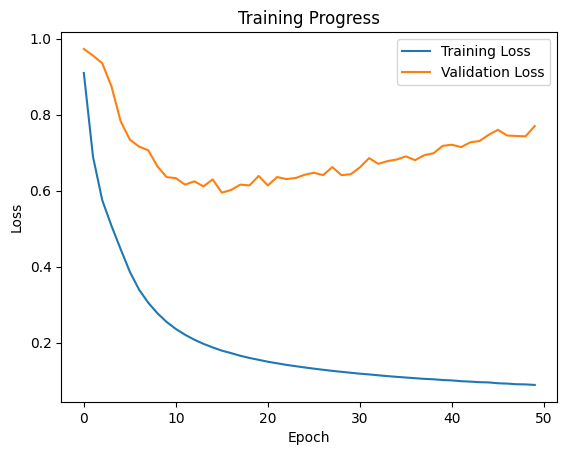

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
def find_errors(num_errors=5):
    count = 0
    for i, (eng, khm) in enumerate(dataset):
        pred = predict_khmer(eng)
        if pred != khm:
            print(f"Error {count+1}:")
            print(f"Input: {eng}")
            print(f"True: {khm}")
            print(f"Pred: {pred}\n")
            count += 1
            if count >= num_errors:
                break

print("\nCommon errors:")
find_errors()


Common errors:
Error 1:
Input: ban
True: បាន
Pred: ប៉ាន់

Error 2:
Input: mean
True: មាន
Pred: មាន់

Error 3:
Input: del
True: ដែល
Pred: ដិល

Error 4:
Input: dl
True: ដែល
Pred: ដ្ល

Error 5:
Input: nis
True: នេះ
Pred: និស



In [ ]:
!pip install gradio

import gradio as gr

def transliterate(english):
    return predict_khmer(english)

interface = gr.Interface(
    fn=transliterate,
    inputs=gr.Textbox(label="English Pronunciation"),
    outputs=gr.Textbox(label="Khmer Text"),
    examples=[["srolanh"], ["kng"], ["hning"]]
)

interface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e59477fea44e6c49d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spac